In [428]:
import pandas as pd
import numpy as np
import random
import os
from scipy import signal
import statsmodels
from scipy.stats import norm
from math import factorial
import time
from scipy import stats
import scipy as scipy
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
pd.options.display.float_format = '{:,.6f}'.format
np.set_printoptions(threshold=5)
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pyplot import figure
from sklearn import neighbors
import statsmodels.api as sm
from sklearn.metrics import confusion_matrix

In [2]:
import os
from pandas_datareader import data as pdr
import pandas as pd
import yfinance as yf
from sklearn import decomposition
from sklearn.decomposition import SparsePCA
from sklearn.linear_model import RANSACRegressor

yf.pdr_override()

START_DATE = "2010-01-01"
END_DATE = "2015-01-01"

In [3]:
tickers_mapping = pd.read_csv('Tickers.csv',  encoding='latin-1')
tickers_sorted = tickers_mapping.sort_values(['Sector']).Symbol
tickers_mapping.index = tickers_mapping['Symbol']

In [4]:
prices = pd.read_csv('stocks.csv')
prices.index = pd.DatetimeIndex(prices['Unnamed: 0'])
prices = prices.iloc[:,1:]
index = pd.read_csv('index.csv')
index.index = pd.DatetimeIndex(index['Date'])
raw_prices = pd.concat([prices, index['Adj Close'].rename('INDEX')], axis=1)        

returns = raw_prices.pct_change(1)
std_returns = returns.div(returns.std(0), 1)

betas = ((returns.rolling(60).corr(returns['INDEX']))*\
                            (returns.rolling(60).std().div(returns['INDEX'].rolling(60).std(),axis = 0))).shift(1)
idio_returns = returns - betas.mul(returns['INDEX'], axis = 0)
idio_std_returns = idio_returns.div(idio_returns.std(0), 1)

In [5]:
prices = pd.read_csv('stocks2.csv')
prices.index = pd.DatetimeIndex(prices['Unnamed: 0'])
prices = prices.iloc[:,1:]
index = pd.read_csv('index2.csv')
index.index = pd.DatetimeIndex(index['Date'])
raw_prices2 = pd.concat([prices, index['Adj Close'].rename('INDEX')], axis=1)        

returns2 = raw_prices2.pct_change(1)
std_returns2 = returns2.div(returns2.std(0), 1)

betas2 = ((returns2.rolling(60).corr(returns2['INDEX']))*\
                            (returns2.rolling(60).std().div(returns2['INDEX'].rolling(60).std(),axis = 0))).shift(1)
idio_returns2 = returns2 - betas2.mul(returns2['INDEX'], axis = 0)
idio_std_returns2 = idio_returns2.div(idio_returns2.std(0), 1)

In [6]:
clean_returns = returns.loc[:,tickers_sorted].dropna(0, how = 'all').dropna(1)
clean_idio_returns = idio_returns.loc[:,tickers_sorted].dropna(0, how = 'all').dropna(1)
clean_idio_std_returns = idio_std_returns.loc[:,tickers_sorted].dropna(0, how = 'all').dropna(1)

clean_returns2 = returns2.loc[:,tickers_sorted].dropna(0, how = 'all').dropna(1)
clean_idio_returns2 = idio_returns2.loc[:,tickers_sorted].dropna(0, how = 'all').dropna(1)
clean_idio_std_returns2 = idio_std_returns2.loc[:,tickers_sorted].dropna(0, how = 'all').dropna(1)

In [7]:
clean_returns = clean_returns.loc[:,list(set(clean_idio_returns.columns) & set(clean_idio_returns2.columns))]
clean_idio_returns = clean_idio_returns.loc[:,list(set(clean_idio_returns.columns) & set(clean_idio_returns2.columns))]
clean_idio_std_returns = clean_idio_std_returns.loc[:,list(set(clean_idio_returns.columns) & set(clean_idio_returns2.columns))]

clean_returns2 = clean_returns2.loc[:,list(set(clean_idio_returns.columns) & set(clean_idio_returns2.columns))]
clean_idio_returns2 = clean_idio_returns2.loc[:,list(set(clean_idio_returns.columns) & set(clean_idio_returns2.columns))]
clean_idio_std_returns2 = clean_idio_std_returns2.loc[:,list(set(clean_idio_returns.columns)&set(clean_idio_returns2.columns))]

In [8]:
clean_idio_std_returns.shape, clean_idio_std_returns2.shape

((1197, 447), (1198, 447))

Model

Demo

In [237]:
from sklearn.datasets import load_iris
from sklearn.inspection import permutation_importance
from sklearn.tree import DecisionTreeClassifier
from sklearn.inspection import plot_partial_dependence
from sklearn.tree import plot_tree
from sklearn.ensemble import (BaggingClassifier, RandomForestClassifier,
                              GradientBoostingClassifier, StackingClassifier)

In [356]:
input_returns = clean_idio_returns
lags = 5
iteration = 1
stock = 'MSFT'
returns_table = input_returns.iloc[iteration:].rolling(lags).mean()[::lags]
rhs = returns_table.shift(1).dropna()
lhs = returns_table[[stock]].reindex(rhs.index)
lhs = pd.DataFrame(np.where(lhs > 0.0, 1, 0), index = lhs.index, columns = lhs.columns)

In [357]:
clf = DecisionTreeClassifier(criterion='entropy', splitter='best', \
                             max_depth=20, min_samples_split=0.1, min_samples_leaf=0.05, \
                             max_features=1.0, random_state=0, ccp_alpha=0.046)
clf = clf.fit(rhs, lhs)

In [191]:
clf = DecisionTreeClassifier(criterion='entropy', splitter='best', \
                             max_depth=20, min_samples_split=0.1, min_samples_leaf=0.05, \
                             max_features=1.0, random_state=0, ccp_alpha=0.046)

bcf = BaggingClassifier(base_estimator=clf, n_estimators=10, max_samples=0.8, max_features=0.2, \
                  bootstrap = False, bootstrap_features = False, random_state = 0)
bcf.fit(rhs, lhs)

BaggingClassifier(base_estimator=DecisionTreeClassifier(ccp_alpha=0.046,
                                                        criterion='entropy',
                                                        max_depth=20,
                                                        max_features=1.0,
                                                        min_samples_leaf=0.05,
                                                        min_samples_split=0.1,
                                                        random_state=0),
                  bootstrap=False, max_features=0.2, max_samples=0.8,
                  random_state=0)

In [254]:
rlf = RandomForestClassifier(n_estimators=100, criterion='entropy', 
                             max_depth=20, min_samples_split=0.1, min_samples_leaf=0.05, \
                             max_features= 'auto', random_state=0, ccp_alpha=0.046)

rlf.fit(rhs, lhs)

RandomForestClassifier(ccp_alpha=0.046, criterion='entropy', max_depth=20,
                       min_samples_leaf=0.05, min_samples_split=0.1,
                       random_state=0)

In [425]:
gbf = GradientBoostingClassifier(loss='deviance', learning_rate=0.1, n_estimators=100, \
                                 subsample=1.0, max_features=1.0, criterion='friedman_mse', \
                                 min_samples_split=0.1, min_samples_leaf=0.05, max_depth=5, \
                                 random_state=0, validation_fraction=0.1, n_iter_no_change = 5, ccp_alpha=0.01)

gbf.fit(rhs, lhs)

GradientBoostingClassifier(ccp_alpha=0.01, max_depth=5, max_features=1.0,
                           min_samples_leaf=0.05, min_samples_split=0.1,
                           n_iter_no_change=5, random_state=0)

In [426]:
gbf.n_estimators_, [tree[0].get_depth() for tree in list(gbf.estimators_)]

(8, [5, 5, 5, 5, 4, 2, 2, 5])

In [427]:
importances = gbf.feature_importances_
mean = np.mean([tree[0].feature_importances_ for tree in list(gbf.estimators_)], axis=0)
std = np.std([tree[0].feature_importances_ for tree in list(gbf.estimators_)], axis=0)

pd.DataFrame({'imp': importances, 'mean': mean, 'std': std}, index= rhs.columns).sort_values(by='imp', ascending=False)[:5]

,imp,mean,std
IBM,0.119147,0.102070,0.105541
AMD,0.058028,0.092241,0.131075
INTU,0.054211,0.042518,0.112493
GPS,0.052927,0.035029,0.060754
ALGN,0.049150,0.059995,0.116738


In [380]:
one = RandomForestClassifier(n_estimators=100, criterion='entropy', 
                             max_depth=20, min_samples_split=0.1, min_samples_leaf=0.05, \
                             max_features= 'auto', random_state=0, ccp_alpha=0.046)
two = GradientBoostingClassifier(loss='deviance', learning_rate=0.1, n_estimators=100, \
                                 subsample=1.0, max_features=0.8, criterion='friedman_mse', \
                                 min_samples_split=0.1, min_samples_leaf=0.05, max_depth=5, \
                                 random_state=0, validation_fraction=0.1, n_iter_no_change = 1, ccp_alpha=0.01)

one = clf
two = gbf
estimators = [('rf', one), ('gb', two)]

sf = StackingClassifier(estimators)
sf.fit(rhs, lhs)

StackingClassifier(estimators=[('rf',
                                DecisionTreeClassifier(ccp_alpha=0.046,
                                                       criterion='entropy',
                                                       max_depth=20,
                                                       max_features=1.0,
                                                       min_samples_leaf=0.05,
                                                       min_samples_split=0.1,
                                                       random_state=0)),
                               ('gb',
                                GradientBoostingClassifier(ccp_alpha=0.01,
                                                           max_depth=5,
                                                           max_features=0.8,
                                                           min_samples_leaf=0.05,
                                                           min_samples_split=0.1,
                 

In [381]:
sf.final_estimator_.coef_

array([[-0.07699178, -0.4672335 ]])

In [365]:
sf.estimators[1][1].estimators_

array([[DecisionTreeRegressor(ccp_alpha=0.01, criterion='friedman_mse', max_depth=5,
                      max_features=0.8, min_samples_leaf=0.05,
                      min_samples_split=0.1,
                      random_state=RandomState(MT19937) at 0x1FE19644048)],
       [DecisionTreeRegressor(ccp_alpha=0.01, criterion='friedman_mse', max_depth=5,
                      max_features=0.8, min_samples_leaf=0.05,
                      min_samples_split=0.1,
                      random_state=RandomState(MT19937) at 0x1FE19644048)],
       [DecisionTreeRegressor(ccp_alpha=0.01, criterion='friedman_mse', max_depth=5,
                      max_features=0.8, min_samples_leaf=0.05,
                      min_samples_split=0.1,
                      random_state=RandomState(MT19937) at 0x1FE19644048)]],
      dtype=object)

In [343]:
list(gbf.estimators_)[1][0]

DecisionTreeRegressor(ccp_alpha=0.01, criterion='friedman_mse', max_depth=5,
                      max_features=0.8, min_samples_leaf=0.05,
                      min_samples_split=0.1,
                      random_state=RandomState(MT19937) at 0x1FE19644048)

In [344]:
[tree[0].get_depth() for tree in list(gbf.estimators_)]

[5, 5, 5]

In [347]:
importances = gbf.feature_importances_
mean = np.mean([tree[0].feature_importances_ for tree in list(gbf.estimators_)], axis=0)
std = np.std([tree[0].feature_importances_ for tree in list(gbf.estimators_)], axis=0)

pd.DataFrame({'imp': importances, 'mean': mean, 'std': std}, index= rhs.columns).sort_values(by='imp', ascending=False)[:5]

,imp,mean,std
IBM,0.133719,0.152197,0.112925
NTRS,0.058360,0.067374,0.095282
WYNN,0.056780,0.065550,0.092702
LHX,0.056199,0.062684,0.088648
AMD,0.055753,0.045062,0.063727


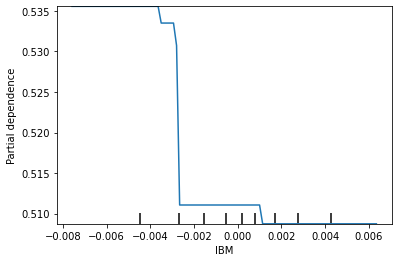

In [310]:
plot_partial_dependence(rlf, rhs, [36])

In [223]:
importances = rlf.feature_importances_
mean = np.mean([tree.feature_importances_ for tree in rlf.estimators_], axis=0)
std = np.std([tree.feature_importances_ for tree in rlf.estimators_], axis=0)

pd.DataFrame({'imp': importances, 'mean': mean, 'std': mean}, index= rhs.columns).sort_values(by='imp', ascending=False)[:5]

,imp,mean,std
SCHW,0.020948,0.020948,0.020948
IBM,0.019069,0.019069,0.019069
SLB,0.017704,0.017704,0.017704
STT,0.016978,0.016978,0.016978
MRK,0.016006,0.016006,0.016006


In [236]:
perm_importance = permutation_importance(rlf, rhs, lhs)
pd.DataFrame({'imp': perm_importance.importances_mean}, index= rhs.columns).sort_values(by='imp', ascending=False)[:5]

,imp
IBM,0.014286
GPS,0.009244
CAT,0.005042
MXIM,0.004202
CCI,0.004202


Text(0.5, 1.0, 'Total Impurity vs effective alpha for training set')

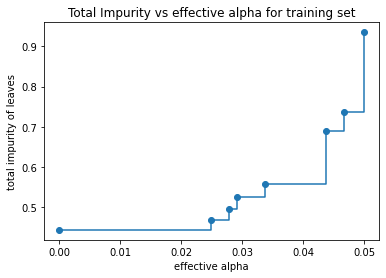

In [162]:
path = clf.cost_complexity_pruning_path(rhs, lhs)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

fig, ax = plt.subplots()
ax.plot(ccp_alphas[:-1], impurities[:-1], marker='o', drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")

In [240]:
clf.get_depth()

5

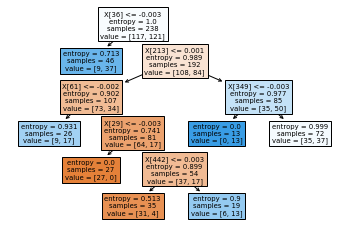

In [247]:
plot_tree(clf, filled=True, feature_names=rhs.columns, class_names=['neg', 'pos'])
plt.show()

In [27]:
pd.DataFrame({'col_name': clf.feature_importances_}, index=rhs.columns).sort_values(by='col_name', ascending=False)[:5]

,col_name
IBM,0.156739
C,0.113129
POOL,0.112771
CF,0.106758
SYY,0.103920


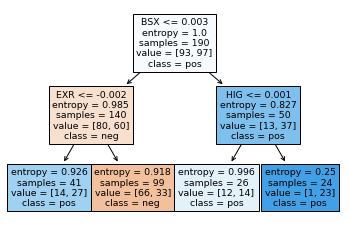

In [192]:
plot_tree(bcf.estimators_[1], filled=True, feature_names=rhs.columns, class_names=['neg', 'pos'])
plt.show()

((100, 10),
 <sklearn.inspection._plot.partial_dependence.PartialDependenceDisplay at 0x1fe15501148>)

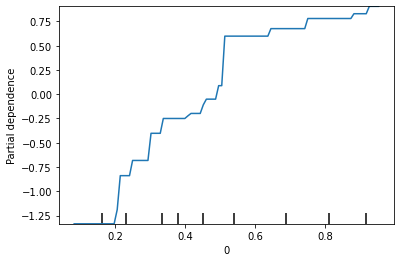

In [257]:
from sklearn.datasets import make_friedman1
from sklearn.ensemble import GradientBoostingRegressor
X, y = make_friedman1()
clf = GradientBoostingRegressor(n_estimators=10).fit(X, y)
X.shape, plot_partial_dependence(clf, X, [0])

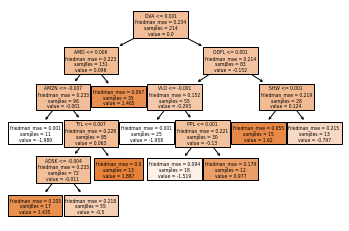

In [346]:
plot_tree(list(gbf.estimators_)[1][0], filled=True, feature_names=rhs.columns, class_names=['neg', 'pos'])
plt.show()